# Analysis of Historical Texts

In this tutorial, we'll explore principal component analysis (PCA), a dimensionality reduction technique.  We'll apply PCA to a body of historical texts in philosophy, history, and literature from the ancient Greeks and Romans and a few more modern writers.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import codecs
from collections import defaultdict
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Reading Documents

I had downloaded the documents from [Project Gutenberg](https://www.gutenberg.org/) as text files and stored them in a local directory.  We need to read each file and convert it to a single string per document.

In [2]:
def read_text(flname):
    with codecs.open(flname, "r", "utf_8",) as fl:
        lines = [ln.strip() for ln in fl]
        text = " ".join(lines)
    return text

In [3]:
raw_texts = dict()
for flname in glob.glob("text_data/*.txt"):
    text = read_text(flname)
    name = os.path.basename(flname)
    raw_texts[name] = text

In [4]:
for flname in sorted(raw_texts.keys()):
    print(flname)

adam_smith_wealth_of_nations.txt
aeschylus_oresteia.txt
aeschylus_prometheus_bound.txt
aquinas_summa_theologica_parts_i_ii.txt
aquinas_summa_theologica_parts_iii.txt
aristophanes_birds.txt
aristophanes_clouds.txt
aristophanes_frogs.txt
aristophanes_lystrata.txt
aristotle_ethics.txt
augustine_city_of_god_i.txt
augustine_city_of_god_ii.txt
augustine_confessions.txt
david_hume_enquiry_concerning_human_understanding.txt
descarte_discourse.txt
euripedes_bacchae.txt
euripedes_electra.txt
euripedes_medea.txt
euripedes_trojan_women.txt
gibbon_decline_and_fall_i.txt
gibbon_decline_and_fall_ii.txt
gibbon_decline_and_fall_iii.txt
gibbon_decline_and_fall_iv.txt
gibbon_decline_and_fall_v.txt
gibbon_decline_and_fall_vi.txt
hegel_philosophy.txt
herodotus_history_i.txt
herodotus_history_ii.txt
hobbes_leviathan.txt
homer_iliad.txt
homer_odyssey.txt
kant_critique_practical_reason.txt
kant_critique_pure_reason.txt
livy_history_book_1.txt
livy_history_book_27.txt
livy_history_book_37.txt
livy_history_book

I've manually characterized the works and used those characterizations to create labels.

In [5]:
colors = []
labels = []
categories = defaultdict(list)
for k in raw_texts.keys():
    if "sophocles" in k or "aeschylus" in k or "euripedes" in k:
        colors.append("m.")
        labels.append("Greek Tragedy")
        categories["Greek Tragedy"].append(k)
    elif "plato" in k or "aristotle" in k:
        colors.append("g.")
        labels.append("Greek Philosophy")
        categories["Greek Philosophy"].append(k)
    elif "aristophanes" in k:
        colors.append("m+")
        labels.append("Greek Comedy")
        categories["Greek Comedy"].append(k)
    elif "homer" in k or "aeneid" in k:
        colors.append("y.")
        labels.append("Epic Poems")
        categories["Epic Poems"].append(k)
    elif "augustine" in k or "aquinas" in k:
        colors.append("go")
        labels.append("Catholic Philosophy")
        categories["Catholic Philosophy"].append(k)
    elif "kant" in k or "hume" in k or "smith" in k or "hobbes" in k or "locke" in k or "spinoza" in k or "marx" in k or "hegel" in k or "descarte" in k:
        colors.append("g+")
        categories["Modern Philosophy"].append(k)
        labels.append("Modern Philosophy")
    elif "gibbon" in k:
        colors.append("c.")
        categories["Gibbon"].append(k)
        labels.append("Gibbon")
    elif "tacitus" in k or "livy" in k:
        colors.append("cd")
        labels.append("Roman Historian")
        categories["Roman Historian"].append(k)
    elif "herodotus" in k or "thucydides" in k or "xenophon" in k:
        colors.append("c+")
        labels.append("Greek Historian")
        categories["Greek Historian"].append(k)
    else:
        print(k)

colors = np.array(colors)
labels = np.array(labels)

In [6]:
for category, flnames in categories.items():
    print("Category:", category)
    for flname in flnames:
        print("\t" + flname)
    print()

Category: Modern Philosophy
	adam_smith_wealth_of_nations.txt
	david_hume_enquiry_concerning_human_understanding.txt
	descarte_discourse.txt
	hegel_philosophy.txt
	hobbes_leviathan.txt
	kant_critique_practical_reason.txt
	kant_critique_pure_reason.txt
	locke_humane_understanding_i.txt
	locke_humane_understanding_ii.txt
	marx_communist.txt
	spinoza_ethics.txt

Category: Greek Tragedy
	aeschylus_oresteia.txt
	aeschylus_prometheus_bound.txt
	euripedes_bacchae.txt
	euripedes_electra.txt
	euripedes_medea.txt
	euripedes_trojan_women.txt
	sophocles_oedipus_trilogy.txt

Category: Catholic Philosophy
	aquinas_summa_theologica_parts_iii.txt
	aquinas_summa_theologica_parts_i_ii.txt
	augustine_city_of_god_i.txt
	augustine_city_of_god_ii.txt
	augustine_confessions.txt

Category: Greek Comedy
	aristophanes_birds.txt
	aristophanes_clouds.txt
	aristophanes_frogs.txt
	aristophanes_lystrata.txt

Category: Greek Philosophy
	aristotle_ethics.txt
	plato_apology.txt
	plato_crito.txt
	plato_meno.txt
	plato_r

## Feature Extraction

Now, how do we turn text into a vector of numerical features we can pass to a machine learning algorithm?  Scikit-learn provides several classes such as [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) that can handle processing the text to produce numerical vectors.

The vectorizer uses a "bag of words" model.  In this model, each word is given a unique index in the numerical vectors.  At the most basic level, the vectorizer will:

* Create a vocabulary
    * Split each document string into a set of words (no duplications)
    * Merge the sets across all documents to create a single vocabulary
    * Assign each word in the vocobulary to a unique index.  If there are 30,000 unique words, we should expect the vectorizer to output vectors of length 30,000
* Transform each document
    * Create a feature vector for each document
    * If using counts, set each element to the number of times the associated word appears
    * If binary, round entries to 0 or 1


The vectorizer has a number of advanced options as well:

* Skip words that appear in fewer documents than a cutoff (min_df)
    * Used to remove very specific words that would cause overlap 
* Skip words that appear more documents than a cutoff (max_df)
    * Remove generic words like "a", "an", and "the" which appear frequently but may not contribute much
* Converting all words to lowercase (on by default)
* Strip accents
* Remove "stop words" (e.g., articles like "a", "an", and "the")

The vectorizer also implements Text Frequency-Inverse Document Frequency (TfIdf) weighting. 

In [7]:
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True)
text_features = vectorizer.fit_transform(raw_texts.values())

In [8]:
print(text_features.shape)

(52, 18555)


Notice that the text feature matrix has ~18,600 columns! The vectorizer produces a *sparse* matrix.  This is a special data structure provided by the Scipy library.  A sparse matrix is similar to a Numpy matrix in how it works.  Internally, the sparse matrix avoids storing zeros.

In [9]:
type(text_features)

scipy.sparse.csr.csr_matrix

In [10]:
list(vectorizer.vocabulary_)[:10]

['inquiry',
 'causes',
 'wealth',
 'nations',
 'adam',
 'smith',
 'anyone',
 'whatsoever',
 'posting',
 'february']

## Supervised Learning

Let's try classifying our documents using a Logistic Regression model.  We can confirm that our categorization of the documents are reasonable and distinguishable.

In [11]:
encoder = LabelEncoder()
numerical_labels = encoder.fit_transform(labels)

training_X, testing_X, training_y, testing_y = train_test_split(text_features,
                                                               numerical_labels,
                                                               stratify=numerical_labels)

lr = SGDClassifier(loss="log", penalty="l2", n_iter=5000)
lr.fit(training_X, training_y)
pred_labels = lr.predict(testing_X)

accuracy = accuracy_score(testing_y, pred_labels)
cm = confusion_matrix(testing_y, pred_labels)

print("Accuracy:", accuracy)
print("Classes:", str(encoder.classes_))
print("Confusion Matrix:")
print(cm)

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy: 0.9230769230769231
Classes: ['Catholic Philosophy' 'Epic Poems' 'Gibbon' 'Greek Comedy'
 'Greek Historian' 'Greek Philosophy' 'Greek Tragedy' 'Modern Philosophy'
 'Roman Historian']
Confusion Matrix:
[[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 1]]


## Dimensionality Reduction

Now that we've confirmed that our categories are reasonable, let's imagine how we might want to do some exploratory data analysis.  With 18,600 features, we can't reasonable generate plots for each feature.

This is where Principal Component Analysis (PCA) comes in.  PCA reduces the dimensions of our data by finding aggregate variables.  We'll see below that we can reduce our data from 18,555 features to 4.  By reducing the variables, we can then more easily plot the relationships between the samples and visualize our data.  We can also use those new variables in our logistic regression model.

Scikit Learn provides a [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class.  This class doesn't work well with sparse matrices so we use a very similar method called Singular Value Decomposition (SVD).  Scikit Learn provides a method called [Truncated SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) that can be used in place of PCA for sparse matrices.

We start by fitting and transforming the data.  We have to "guess" the maximum number of new variables (components) we may want.

In [12]:
svd = TruncatedSVD(n_components = 10)
projected = svd.fit_transform(text_features)

In [13]:
print(projected.shape)

(52, 10)


We can then confirm which new variables we want to use by plotting their "explained variance ratios."  In our case, components 1-4 have the highest explained variance ratios.

Text(0,0.5,'Explained Variance Ratio')

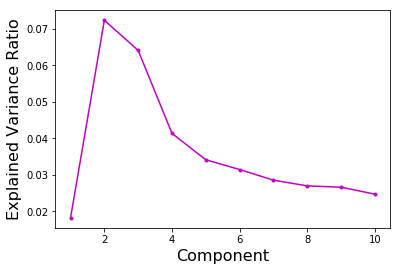

In [14]:
plt.clf()
plt.plot(range(1, 11), svd.explained_variance_ratio_, "m.-")
plt.xlabel("Component", fontsize=16)
plt.ylabel("Explained Variance Ratio", fontsize=16)

Since components 1 and 2 have the absolute highest explained variance ratios, let's create a scatter plot of variables using just those two variables.  We'll see that our documents tend to cluster by category.

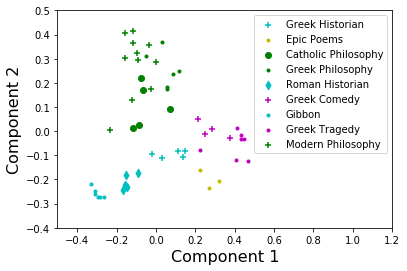

In [15]:
plt.clf()
for l in set(labels):
    selected = [i for i, l_ in enumerate(labels) if l == l_]
    plt.scatter(projected[selected, 1],
                projected[selected, 2],
                marker = colors[selected][0][1],
                color = colors[selected][0][0],
                label = l)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.xlim([-0.5, 1.2])
plt.ylim([-0.4, 0.5])
plt.legend()

Lastly, let's try building a logistic regression model using only components 1-4 and comparing its accuracy to our original model.

In [16]:
training_X, testing_X, training_y, testing_y = train_test_split(projected[:, 1:5],
                                                               numerical_labels,
                                                               stratify=numerical_labels)

lr = SGDClassifier(loss="log", penalty="l2", n_iter=5000)
lr.fit(training_X, training_y)
pred_labels = lr.predict(testing_X)

accuracy = accuracy_score(testing_y, pred_labels)
cm = confusion_matrix(testing_y, pred_labels)

print("Accuracy:", accuracy)
print("Classes:", str(encoder.classes_))
print("Confusion Matrix:")
print(cm)

Accuracy: 0.6923076923076923
Classes: ['Catholic Philosophy' 'Epic Poems' 'Gibbon' 'Greek Comedy'
 'Greek Historian' 'Greek Philosophy' 'Greek Tragedy' 'Modern Philosophy'
 'Roman Historian']
Confusion Matrix:
[[1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 2 0 1 0]
 [0 0 0 0 0 0 0 0 1]]


C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Our model that uses the new PC variables achieves a similar accuracy.